# DOOM or Animal Crossing????

Importing libraries

In [ ]:
import keras
import os
import glob
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential

2024-02-13 20:23:27.036649: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-13 20:23:27.036749: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-13 20:23:27.175443: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Importing and Loading the data into a data frame

In [ ]:
dataset_path = r'/kaggle/input/doom-crossing'
class_names = ['animal_crossing','doom']

Applying glob module to retrieve files/pathnames  

In [ ]:
scan_path = os.path.join(dataset_path, class_names[1], '*')
scan_path = glob.glob(scan_path)

Accessing an image file from the dataset classes

In [ ]:
image = io.imread(scan_path[4])

Plotting an image

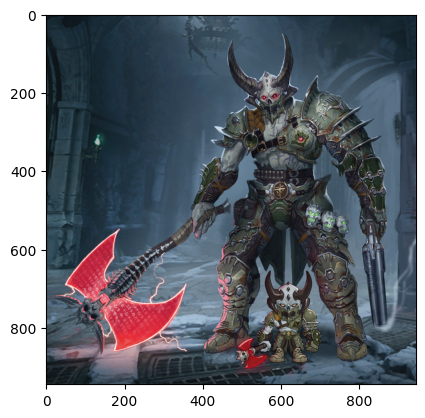

In [ ]:
i, (im1) = plt.subplots(1)
i.set_figwidth(15)
im1.imshow(image)

Data preparation

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Splitting into train and test

In [ ]:

train_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Data exploration & visualization

In [ ]:
class_names = train_ds.class_names
print(class_names)

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Processing

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Normalization

Found 1597 files belonging to 2 classes.
Using 1278 files for training.
Found 1597 files belonging to 2 classes.
Using 319 files for validation.
['animal_crossing', 'doom']


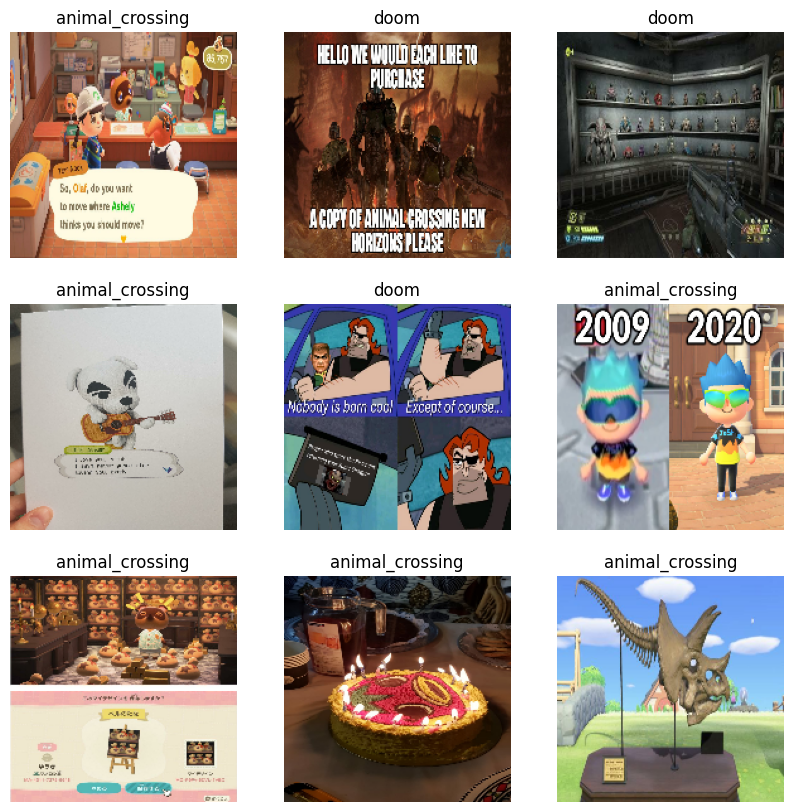

In [ ]:
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

Notice the pixel values are now in [0,1]

In [ ]:
print(np.min(first_image), np.max(first_image))

num_classes = len(class_names)

0.0 1.0


data augmentation

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Constructing the model

In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

Model compilation& summary

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model training

In [ ]:
epochs = 200
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
)

Training results:

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

2024-02-13 20:25:08.167200: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1707855910.845188     107 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


40/40 [==============================] - 12s 171ms/step - loss: 0.7546 - accuracy: 0.6354 - val_loss: 0.7187 - val_accuracy: 0.6489
Epoch 2/200
40/40 [==============================] - 1s 22ms/step - loss: 0.5575 - accuracy: 0.6925 - val_loss: 0.5882 - val_accuracy: 0.7210
Epoch 3/200
40/40 [==============================] - 1s 22ms/step - loss: 0.5717 - accuracy: 0.7089 - val_loss: 0.5855 - val_accuracy: 0.7273
Epoch 4/200
40/40 [==============================] - 1s 23ms/step - loss: 0.5311 - accuracy: 0.7254 - val_loss: 0.5708 - val_accuracy: 0.7398
Epoch 5/200
40/40 [==============================] - 1s 23ms/step - loss: 0.4761 - accuracy: 0.7707 - val_loss: 0.5061 - val_accuracy: 0.7618
Epoch 6/200
40/40 [==============================] - 1s 23ms/step - loss: 0.4713 - accuracy: 0.7692 - val_loss: 0.5394 - val_accuracy: 0.7367
Epoch 7/200
40/40 [==============================] - 1s 22ms/step - loss: 0.5070 - accuracy: 0.7567 - val_loss: 0.6678 - val_accuracy: 0.6834
Epoch 8/200
40/4

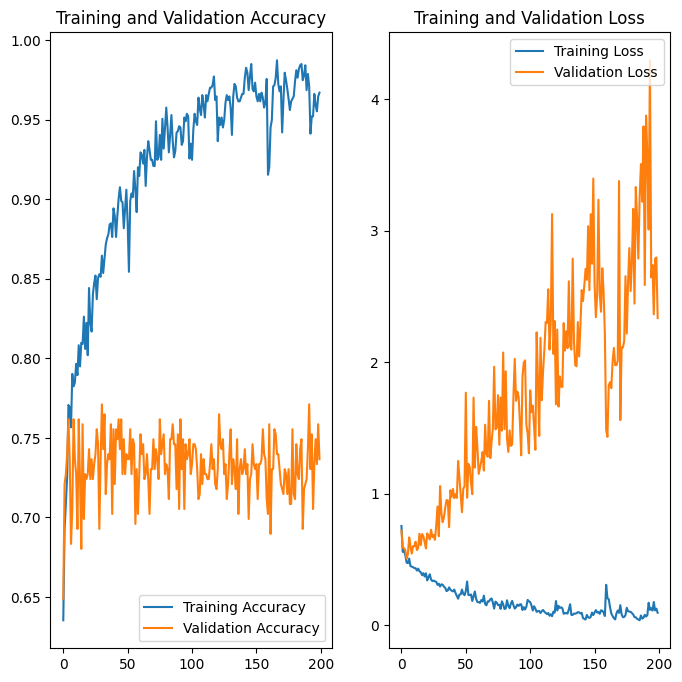

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Serializing model to JSON

In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

Serializing model to h5

In [ ]:
model.save(f'/kaggle/working/model',save_format="h5")
print("saved model on disk")

saved model on disk


Prediction

1/1 [==============================] - 0s 22ms/step
This image most likely belongs to animal_crossing with a 100.00 percent confidence.


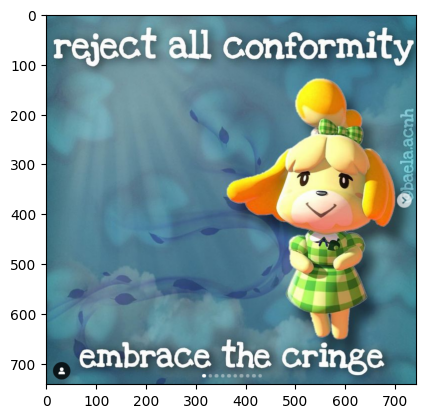

In [ ]:

img_path = r'/kaggle/input/ccccccc/c.png'

img = tf.keras.utils.load_img(
    img_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
image=io.imread('/kaggle/input/ccccccc/c.png')
i, (im1) = plt.subplots(1)
i.set_figwidth(20)
im1.imshow(image)

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)